# Parametrized Burger's Equation vs POD-NN

## 0. Installing and importing the $\texttt{dlroms}$ package

In [36]:
from IPython.display import clear_output
#%pip install git+https://github.com/NicolaRFranco/dlroms.git
clear_output()
print("dlroms package installed and ready to go.")

dlroms package installed and ready to go.


In [37]:
from dlroms import*
import torch

In [38]:
device = CPU

## 1. Problem setup and data generation
Let $\Omega=(-1,1)$. We consider the following parameter dependent Burger's equation
</br></br>
$$
\begin{equation}
\tag{1}
\dfrac{\partial u}{\partial t} + u\dfrac{\partial u}{\partial x} = 0
\end{equation}
$$
</br>

complemented with Neumann boundary conditions, and with the following initial condition
</br></br>
<!---$$u(x,0)=\frac{1 - sin(\frac{\pi}{\alpha} x^3)}{2},\quad\quad x\in\Omega$$-->

$$u(x,0)=\max\left(x+1,\ 0\right)\cdot\left(\frac{\left(1-\ \sin\left(\frac{\pi}{a}x^{2}\right)\right)}{16}+\frac{1}{8}\right)\ +0.5,\quad\quad x\in\Omega$$
</br>

We denote by $\boldsymbol{\mu}=[t, \alpha]$ the (time-extended) vector of parameters. We let $\boldsymbol{\mu}\in[0,2]\times[0.2, 1]$.
</br></br>
NB: The solution to (1) in closed form: thus, we can use the corresponding analytic formula to generate highfidelity data (normally, we would need a FOM solver: here, we avoid this complication for didactical purposes!)

### 1.1 Setup

In [39]:
from phi.flow import *
import numpy as np
import jax.numpy as jnp

from phi import __version__
print("Using phiflow version: {}".format(phi.__version__))

Using phiflow version: 2.5.3


In [40]:
nh = 500
dx = 2./nh
nt = 600
dt = 2./nt

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from torch import exp


# Spacetime discretization
x = device.tensor(np.linspace(-1, 1, nh)) # spatial grid
t = device.tensor(np.linspace(0, 2, nt)) # timepoints

# Uniform sampling of 100 different reynolds numbers
nalpha = 10
alpha_min, alpha_max = 0.2, 1
alphas = device.tensor(np.linspace(0, 1, nalpha)) # we sample in [0,1] in order to work with normalized data
normalize = lambda r: (r-alpha_min)/(alpha_max-alpha_min) # maps [0.5, 2] onto [0, 1]
denormalize = lambda r: r*(alpha_max-alpha_min) + alpha_min # maps [0, 1] onto [0.5, 2]

In [42]:
u_0 = lambda x_, alpha: jnp.max(x_+1, 0) * ((1 - jnp.sin(jnp.pi * jnp.power(x_, 2)/alpha))/16 + 1/8) + 1/2

In [43]:
u0_space = lambda alpha: np.asarray( [u_0(np.array([x_]), np.array([alpha])) for x_ in np.linspace(-1,1,nh)] )

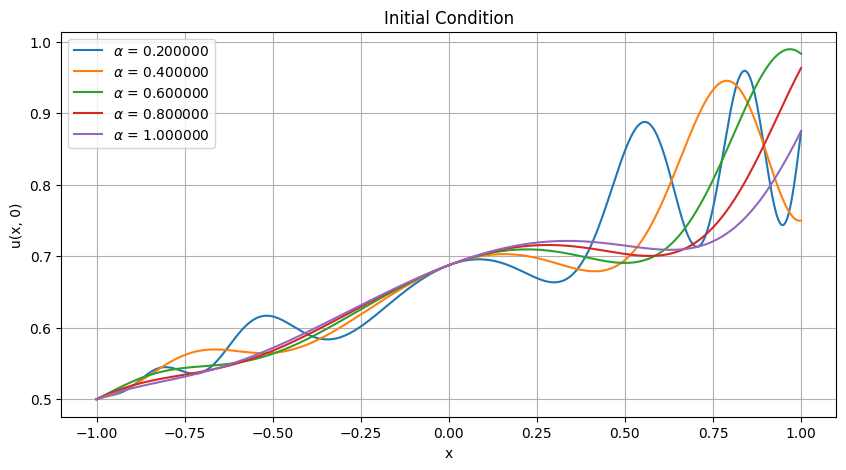

In [44]:
fig = plt.figure(figsize=(10, 5))

for alpha in np.linspace(alpha_min, alpha_max, 5):
    plt.plot(x.numpy(), u0_space(alpha), label=r'$\alpha$ = {:02f}'.format(alpha))
    plt.title('Initial Condition')
    plt.xlabel('x')
    plt.ylabel('u(x, 0)')
    plt.legend()

plt.grid(True)
plt.show()

### 1.2 Data Generation

In [ ]:
alpha_results = {}
for alpha in alphas:
    alpha = denormalize(alpha)
    # initialization of velocities, cell centers of a CenteredGrid have DX/2 offsets for linspace()
    initial_np = u0_space(alpha).squeeze() # 1D numpy array

    initial = math.tensor(initial_np, spatial('x') ) # convert to phiflow tensor
    velocity = CenteredGrid(initial, extrapolation.ZERO_GRADIENT, x=nh, bounds=Box(x=(-1,1)))
    vt = advect.semi_lagrangian(velocity, velocity, dt)
    #velocity = CenteredGrid(lambda x: -math.sin(np.pi * x), extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))
    #velocity = CenteredGrid(Noise(), extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1))) # random init

    print("Velocity tensor shape: "   + format( velocity.shape )) # == velocity.values.shape
    print("Velocity tensor type: "    + format( type(velocity.values) ))
    print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy('x')[10:15] ))
    
    velocities = [velocity]
    age = 0.
    for i in range(nt):
        v1 = diffuse.explicit(velocities[-1], 0, dt)
        v2 = advect.semi_lagrangian(v1, v1, dt)
        age += dt
        velocities.append(v2)

    print("New velocity content at t={}: {}".format( age, velocities[-1].values.numpy('x,vector')[0:5] ))
    normalized_alpha = normalize(alpha.cpu()).numpy().item()
    alpha_results[normalized_alpha] = velocities
    
alphas_pairing = {i:denormalize(k) for i, k in enumerate(alpha_results.keys())}
alpha_results_list = list(alpha_results.values())

Velocity tensor shape: (xˢ=500)
Velocity tensor type: <class 'phiml.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [0.5051508 0.5055752 0.5060259 0.5065139 0.5070496]
New velocity content at t=2.000000000000019: [[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]
Velocity tensor shape: (xˢ=500)
Velocity tensor type: <class 'phiml.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [0.5089206  0.50961703 0.51026857 0.5108747  0.51143545]
New velocity content at t=2.000000000000019: [[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]
Velocity tensor shape: (xˢ=500)
Velocity tensor type: <class 'phiml.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [0.50505567 0.5056002  0.5061634  0.5067478  0.5073557 ]
New velocity content at t=2.000000000000019: [[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]
Velocity tensor shape: (xˢ=500)
Velocity tensor type: <class 'phiml.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [0.5077153  0.5086284  0.50956565 0.51052606 0.51150876]
New veloci

In [ ]:
# save alpha_results_list to a file
import pickle
with open('alpha_results_list.pkl', 'wb') as f:
    pickle.dump(alpha_results_list, f)
    
# save alphas_pairing to a file
import pickle
with open('alphas_pairing.pkl', 'wb') as f:
    pickle.dump(alphas_pairing, f)

### 1.3 Data Analysis

In [45]:
# load alpha_results_list from a file
import pickle
with open('alpha_results_list.pkl', 'rb') as f:
    alpha_results_list = pickle.load(f)
    
# load alphas_pairing from a file
import pickle
with open('alphas_pairing.pkl', 'rb') as f:
    alphas_pairing = pickle.load(f)

In [46]:
u_ground_truth = np.asarray([[v.values.numpy('x,vector') for v in result_list_][:-1] for result_list_ in alpha_results_list]).squeeze(-1)
u_ground_truth.shape

(10, 600, 500)

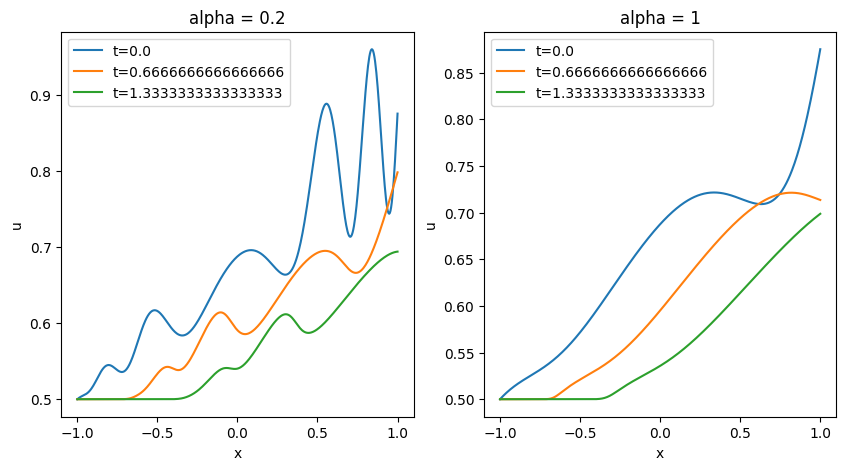

In [47]:
# plot both velocity evoluations in two seperate subplots
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(0, nt, int(nt/3)):
    ax1.plot(np.linspace(-1, 1, nh), u_ground_truth[0][i], label='t={}'.format(i*2/nt))
    ax1.set_title(f'alpha = {alpha_min}')
    ax1.set_xlabel('x')
    ax1.set_ylabel('u')
    ax1.legend()
    ax2.plot(np.linspace(-1, 1, nh), u_ground_truth[-1][i], label='t={}'.format(i*2/nt))
    ax2.set_title(f'alpha = {alpha_max}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('u')
    ax2.legend()    

plt.show()

### 1.4 Data Pre-processing

In [48]:
from torch import cat as torch_cat

# Sampling some trajectories for ROM training (and testing)
u = device.zeros(nalpha, nt, nh) # will contain nalpha trajectories, each with nt timesteps, each with nh spatial values
mu = device.zeros(nalpha, nt, 2)
for i, alpha in enumerate(alphas):
  alpha_res = np.array([v.values.numpy('x,vector') for v in alpha_results_list[i]]).squeeze()
  for j in range(nt):
    u[i,j] = device.tensor(alpha_res[j])
    mu[i,j] = device.tensor([alpha, j*dt])

# We have a total of nre*nt snapshots. How many should we use for training?
training_size = 0.8
ntrain = int(training_size*nt)

# We reshape to operate in "batches". Now u[i] will be the snapshot at t = mu[i,1] and alpha = mu[i,0] (up to renormalizing)
print(u.shape, mu.shape)
# Random permutation to ensure a proper splitting between training and testing
u_train = device.tensor(np.zeros((nalpha, ntrain, nh)))
u_test = device.tensor(np.zeros((nalpha, nt-ntrain, nh)))
mu_train = device.tensor(np.zeros((nalpha, ntrain, 2)))
mu_test = device.tensor(np.zeros((nalpha, nt-ntrain, 2)))

for i, _ in enumerate(alphas):
  perm = np.random.permutation(nt)
  u[i, :] = u[i, perm]
  mu[i, :] = mu[i, perm]
  u_train[i, :] = u[i, :ntrain]
  u_test[i, :] = u[i, ntrain:]
  mu_train[i, :] = mu[i, :ntrain]
  mu_test[i, :] = mu[i, ntrain:]

# u is a concatenation of utrain and utest
u = torch_cat([u_train, u_test], axis=1)
u = u.reshape(-1, nh)

mu = torch_cat([mu_train, mu_test], axis=1)
mu = mu.reshape(-1, 2)

ntrain *= nalpha

u.shape, mu.shape, ntrain, u_train.reshape(-1,nh).shape

torch.Size([10, 600, 500]) torch.Size([10, 600, 2])


(torch.Size([6000, 500]), torch.Size([6000, 2]), 4800, torch.Size([4800, 500]))

## 2. Construction of the POD basis

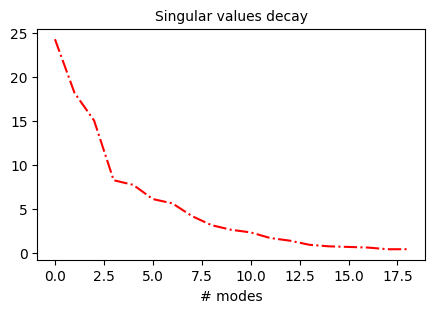

tensor([8.3901e+05, 5.8963e+02, 3.3085e+02, 2.2660e+02, 6.8592e+01, 6.0158e+01,
        3.7778e+01, 3.2037e+01, 1.7761e+01, 1.0140e+01, 7.0917e+00, 5.5929e+00,
        2.9764e+00, 2.0365e+00, 9.1879e-01, 6.1395e-01, 5.1234e-01, 4.1073e-01,
        2.0751e-01, 2.0751e-01])

In [49]:

nmodes = 20
basis, eigs = POD(u[:ntrain], k = nmodes) # POD basis vectors and corresponding eigenvalues (squared singular values)
# NB: "basis" is a nmodes x nh tensor, that is, basis[i] contains the ith POD mode

svalues = eigs.sqrt().cpu() # singular values
plt.figure(figsize = (5,3))
plt.plot(svalues[1:], '-.', color = 'red')
plt.title("Singular values decay", fontsize = 10)
plt.xlabel("# modes")
plt.show()
eigs

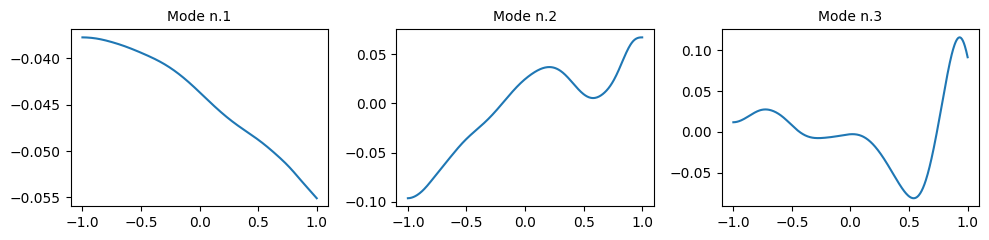

In [50]:
# Let's visualize some of the basis functions
plt.figure(figsize = (10, 2.5))
for j in range(3):
  plt.subplot(1,3,j+1)
  plt.plot(x.cpu(), basis[j].cpu())
  plt.title("Mode n.%d" % (j+1), fontsize = 10)
plt.tight_layout()

## 3. Learning the parameter-to-POD-coefficient map via neural networks
We train a network $\phi$ to learn the mapping $\boldsymbol{\mu}\mapsto \mathbf{c}_{\boldsymbol{\mu}}:=\mathbf{V}^{T}\mathbf{u}_{\boldsymbol{\mu}}$, where $\mathbf{V}$ is the POD basis. Then, the POD-NN [1] approximation reads
</br></br>
$$\mathbf{u}_{\boldsymbol{\mu}}^{\text{ROM}}:=\mathbf{V}\phi(\boldsymbol{\mu})\approx \mathbf{u}_{\boldsymbol{\mu}}.$$

### 3.1 Init


In [51]:
utest, mutest = u[ntrain:], mu[ntrain:]

In [52]:
print("Minimum error threshold possible: %s" % num2p(mre(euclidean)(utest, project(basis, utest)))) # format as a percentage

Minimum error threshold possible: 0.03%


In [53]:
c = projectdown(basis, u).reshape(-1, nmodes) # POD coefficients for each snapshot.

# NB: reshaping is needed because "projectdown(basis, u)" returns a tensor of dimension ndata x nmodes x 1, as to assign
# a "column vector" to each snapshot. We reshape to remove the extra dimension at the end.

In [54]:
from torch import sin, pi, maximum as torch_max, pow as torch_pow

u_0_tensor = lambda x_, alpha: torch_max(x_+1, device.tensor(0)) * ((1 - sin(pi * torch_pow(x_, 2)/alpha))/16 + 1/8) + 1/2 # initial condition

alphas_residual = lambda miu: denormalize(miu[:, [0]]) # alphas with shape (nalpha*nt, nh)
x_param_residual = lambda miu, u: x.reshape(1, -1) - u * miu[:, [1]] # x - u * t with shape (nalpha*nt, nh)
residual = lambda miu, u: (u - u_0_tensor(x_param_residual(miu, u), alphas_residual(miu))).pow(2).mean(-1).sqrt().mean()

#np.tile(np.asarray([[0.5, 1]])[:, 0], x.shape[0]).reshape(-1, x.shape[0])
#device.tensor(u_0(x_matrix, ))
x.shape[0]
#print(residual(miu, rom_miu(miu)))
print(residual(mu, u))


tensor(0.0007)


In [55]:
def measure_acc_residual(rom_test, miu_vals, test, pred):
    return mre(euclidean)(test, pred), residual(miu_vals, rom_test(miu_vals))

In [56]:
def measure_residual(rom_test):
    def res_calc(miu_vals):
        return residual(miu_vals, rom_test(miu_vals))
    return res_calc

In [57]:
n_its = 1250

In [58]:
def euclidean_loss(target, c_pred):
    miu, c_target = target
    return mse(euclidean)(c_target, c_pred)

### 3.2 Base Model

In [25]:
from dlroms.roms import DFNN
import time
p = 2 # total parameters (including time)
hidden_rep = 100
network = DFNN(Dense(2, hidden_rep) + Dense(hidden_rep, hidden_rep) + Dense(hidden_rep, nmodes, activation = None)) # DNN architecture
network.He() # random initialization

In [26]:
rom_miu = lambda miu: projectup(basis, network(miu.reshape(-1, 2)))

miu = device.tensor([[[denormalize(alpha_), time] for time in t] for alpha_ in alphas])
miu.shape, u_ground_truth.shape

(torch.Size([10, 600, 2]), (10, 600, 500))

In [27]:
network.train(mu, (mu, c), ntrain = ntrain, epochs = n_its, loss = euclidean_loss, residual=measure_residual(rom_miu)) # training phase (L-BFGS optimizer, mean squared error loss)
network.freeze() # freezing: all weights and biases have been optimized, so we should just fix them

		Train		Resid.		Test
Epoch 1250:	1.78e-03	3.84e-03	5.25e-02.

>> ETA: 0.33s.

Training complete. Elapsed time: 6 minutes 51.41 seconds.


In [28]:
# save accuracy_lst, res_lst and total_time to a file as a dictionary
import json
with open('accuracy_res_time.json', 'w') as f:
    f.write(json.dumps({'accuracy': list(network.errors['Test']), 'residual': list(network.errors['Residual']), 'time': network.training_time}))

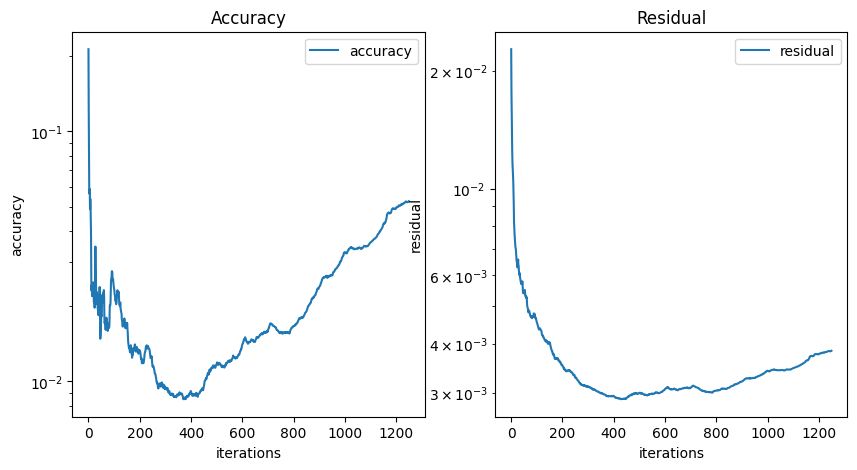

In [29]:
# plot accuracies and residuals in two seperate subplots
# with log y-axis
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(network.errors['Test'], label='accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('iterations')
ax1.set_ylabel('accuracy')
ax1.set_yscale('log')
ax1.legend()

ax2.plot(network.errors['Residual'], label='residual')
ax2.set_title('Residual')
ax2.set_xlabel('iterations')
ax2.set_ylabel('residual')
ax2.set_yscale('log')
ax2.legend()

plt.show()

In [30]:
print(f"Min accuracy: {min(network.errors['Test'])}, Min residual: {min(network.errors['Residual'])}")

Min accuracy: 0.008477263152599335, Min residual: 0.0028887479566037655


In [31]:
# Auxiliary function implementing the ROM for two given float numbers
rom = lambda miu: projectup(basis, network(miu))[0]

In [32]:
# Visual comparison
alpha_vals = [0.2, 1]
times = [0, nt//2, nt-1]

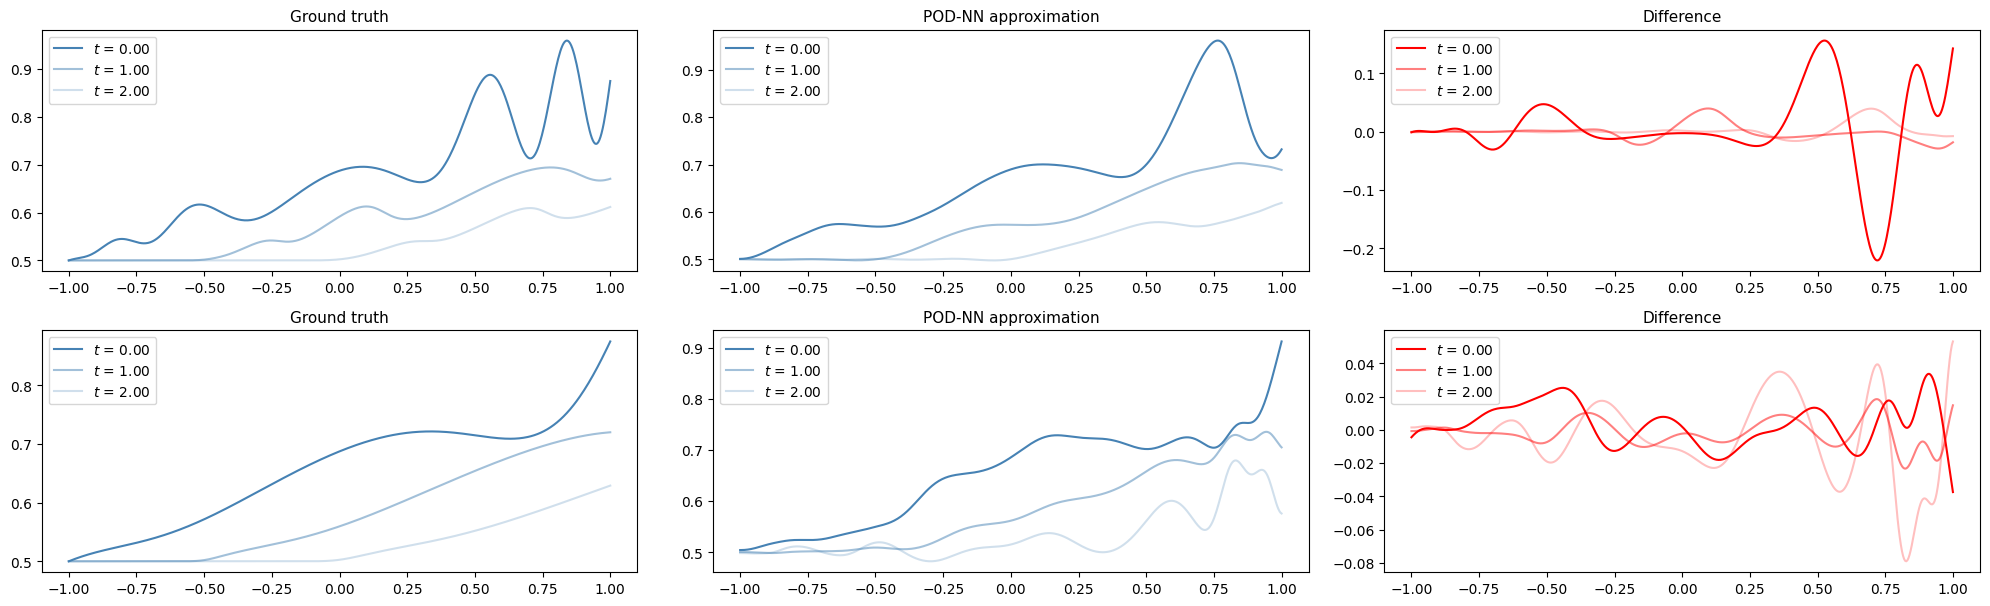

In [33]:
colors = [1.0, 0.5, 0.25]

plt.figure(figsize = (20, 30))
for i, alpha in enumerate(alpha_vals):
  input_tensor = device.tensor([[alpha, t[j]] for j in times])
  appx = np.array([rom(input_tensor[j:j+1, :]).detach().cpu().numpy() for j in range(len(times))])
  gt =  np.array([[v.values.numpy('x,vector') for v in alpha_results_list[0 if i==0 else -1]][j] for j in times]).squeeze()
  for j in range(3):
    plt.subplot(len(denormalize(alphas)),3,i*3 + 1)
    plt.plot(x.cpu(), gt[j], label = "$t$ = %.2f" % t[times[j]], alpha = colors[j], color = 'steelblue')
    plt.title("Ground truth", fontsize = 11)
    plt.legend()
    plt.subplot(len(denormalize(alphas)),3,i*3 + 2)
    plt.plot(x.cpu(), appx[j], label = "$t$ = %.2f" % t[times[j]], alpha = colors[j], color = 'steelblue')
    plt.title("POD-NN approximation", fontsize = 11)
    plt.legend()
    #plt difference
    plt.subplot(len(denormalize(alphas)),3,i*3 + 3)
    plt.plot(x.cpu(), (gt - appx)[j], label = "$t$ = %.2f" % t[times[j]], alpha = colors[j], color = 'red')
    plt.title("Difference", fontsize = 11)
    plt.legend()
plt.tight_layout()

### 3.3 Mixed (Residual + Supervised Loss)

This condition should be satisfied in the Inviscid Burgers' equation:

\begin{equation}
u_{\mu}(x,t,\alpha) = \phi_{\mu}(x - u_{\mu}(x,t,\alpha)t)
\end{equation}

Where:

\begin{equation}
\phi_{\mu}(x,\alpha) = u(x,0,\alpha)
\end{equation}

Thus, we have that the residual $\mathcal{R}$ is:

\begin{equation}
\mathcal{R} = u_{\mu}(x,t,\alpha) - \phi_{\mu}(x - u_{\mu}(x,t,\alpha)t)
\end{equation}

In [24]:
physics_weight = 0.2

def loss_fn(target, c_pred):
    miu, c_target = target
    mse = ((c_pred - c_target)**2).mean()
    u_pred = projectup(basis, c_pred)
    res = residual(miu, u_pred)
    return mse + physics_weight * res

from dlroms.roms import DFNN
import json

p = 2 # total parameters (including time)
hidden_rep = 100
network_physics = DFNN(Dense(2, hidden_rep) + Dense(hidden_rep, hidden_rep) + Dense(hidden_rep, nmodes, activation = None)) # DNN architecture

rom_physics_miu = lambda miu: projectup(basis, network_physics(miu.reshape(-1, 2)))

In [32]:
# vals_list = [0.05, 0.2, 0.5, 0.75, 1, 2]
vals_list = [0.01, 0.1, 0.3, 0.4, 5, 10]
for physics_weight_val in vals_list:
    network_physics = DFNN(Dense(2, hidden_rep) + Dense(hidden_rep, hidden_rep) + Dense(hidden_rep, nmodes, activation = None)) # DNN architecture
    network_physics.He() # random initialization
    
    rom_physics_miu = lambda miu: projectup(basis, network_physics(miu.reshape(-1, 2)))
    network_physics.train(mu, (mu, c), ntrain=ntrain, epochs = n_its, loss = loss_fn, residual=measure_residual(rom_physics_miu), error=euclidean_loss) # training phase (L-BFGS optimizer, mean squared error loss)
    network_physics.freeze() # freezing: all weights and biases have been optimized, so we should just fix them
    
    with open(f'accuracy_res_time_mixed_{physics_weight_val}.json', 'w') as f:
        f.write(json.dumps({'accuracy': list(network_physics.errors['Test']), 'residual': list(network_physics.errors['Residual']), 'time': network_physics.training_time}))

		Train		Resid.		Test
Epoch 1250:	3.23e-03	3.02e-03	3.36e-02.

>> ETA: 1.64s.

Training complete. Elapsed time: 34 minutes 8.54 seconds.


In [33]:
# Visual comparison
alpha_vals = [0.2, 1]
times = [0, nt//2, nt-1]

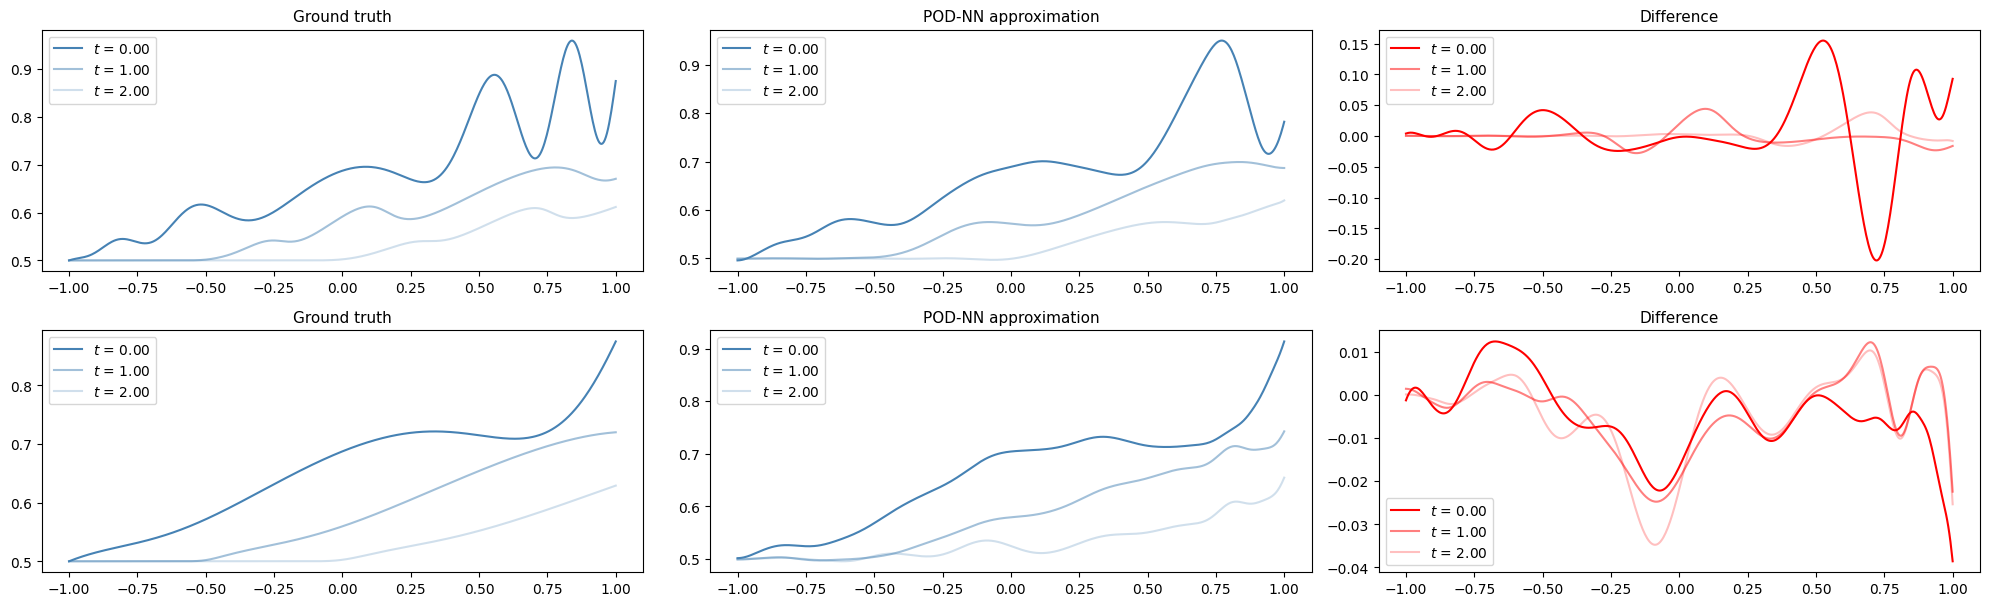

In [34]:
colors = [1.0, 0.5, 0.25]

plt.figure(figsize = (20, 30))
for i, alpha in enumerate(alpha_vals):
  input_tensor = device.tensor([[alpha, t[j]] for j in times])
  appx = np.array([rom_physics_miu(input_tensor[j:j+1, :]).cpu().numpy() for j in range(len(times))])[:, 0, :]
  gt =  np.array([[v.values.numpy('x,vector') for v in alpha_results_list[0 if i==0 else -1]][j] for j in times]).squeeze()
  for j in range(3):
    plt.subplot(len(denormalize(alphas)),3,i*3 + 1)
    plt.plot(x.cpu(), gt[j], label = "$t$ = %.2f" % t[times[j]], alpha = colors[j], color = 'steelblue')
    plt.title("Ground truth", fontsize = 11)
    plt.legend()
    plt.subplot(len(denormalize(alphas)),3,i*3 + 2)
    plt.plot(x.cpu(), appx[j], label = "$t$ = %.2f" % t[times[j]], alpha = colors[j], color = 'steelblue')
    plt.title("POD-NN approximation", fontsize = 11)
    plt.legend()
    #plt difference
    plt.subplot(len(denormalize(alphas)),3,i*3 + 3)
    plt.plot(x.cpu(), (gt - appx)[j], label = "$t$ = %.2f" % t[times[j]], alpha = colors[j], color = 'red')
    plt.title("Difference", fontsize = 11)
    plt.legend()
plt.tight_layout()

### 3.4 Online Phase - Unsupervised (only residual)

In [59]:
def loss_fn(target, c_pred):
    miu, _ = target
    u_pred = projectup(basis, c_pred)
    res = residual(miu, u_pred)
    return res

from dlroms.roms import DFNN
p = 2 # total parameters (including time)
hidden_rep = 100
network_physics_unsupervised = DFNN(Dense(2, hidden_rep) + Dense(hidden_rep, hidden_rep) + Dense(hidden_rep, nmodes, activation = None)) # DNN architecture
network_physics_unsupervised.He() # random initialization
rom_physics_unsupervised_miu = lambda miu: projectup(basis, network_physics_unsupervised(miu.reshape(-1, 2)))

network_physics_unsupervised.train(mu, (mu, c), ntrain = ntrain, epochs = n_its, loss = loss_fn, residual=measure_residual(rom_physics_unsupervised_miu), error=euclidean_loss) # training phase (L-BFGS optimizer, mean squared error loss)
network_physics_unsupervised.freeze() # freezing: all weights and biases have been optimized, so we should just fix them

		Train		Resid.		Test
Epoch 1250:	3.12e-03	3.69e-03	5.79e-02.

>> ETA: 1.59s.

Training complete. Elapsed time: 33 minutes 11.20 seconds.


In [60]:
import json
with open('accuracy_res_time_unsupervised.json', 'w') as f:
    f.write(json.dumps({'accuracy': list(network_physics_unsupervised.errors['Test']), 'residual': list(network_physics_unsupervised.errors['Residual']), 'time': network_physics_unsupervised.training_time}))

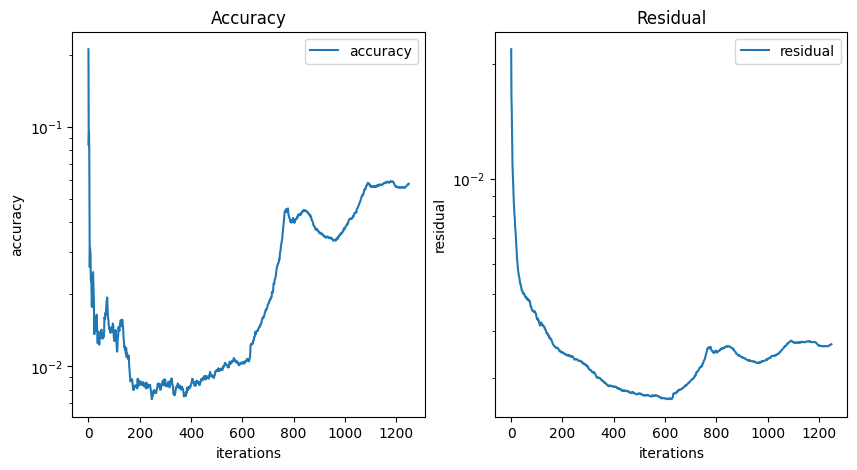

In [61]:
# plot accuracies and residuals in two seperate subplots
# with log y-axis
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(network_physics_unsupervised.errors['Test'], label='accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('iterations')
ax1.set_ylabel('accuracy')
ax1.set_yscale('log')
ax1.legend()

ax2.plot(network_physics_unsupervised.errors['Residual'], label='residual')
ax2.set_title('Residual')
ax2.set_xlabel('iterations')
ax2.set_ylabel('residual')
ax2.set_yscale('log')
ax2.legend()

plt.show()

In [62]:
# Visual comparison
alpha_vals = [0.2, 1]
times = [0, nt//2, nt-1]

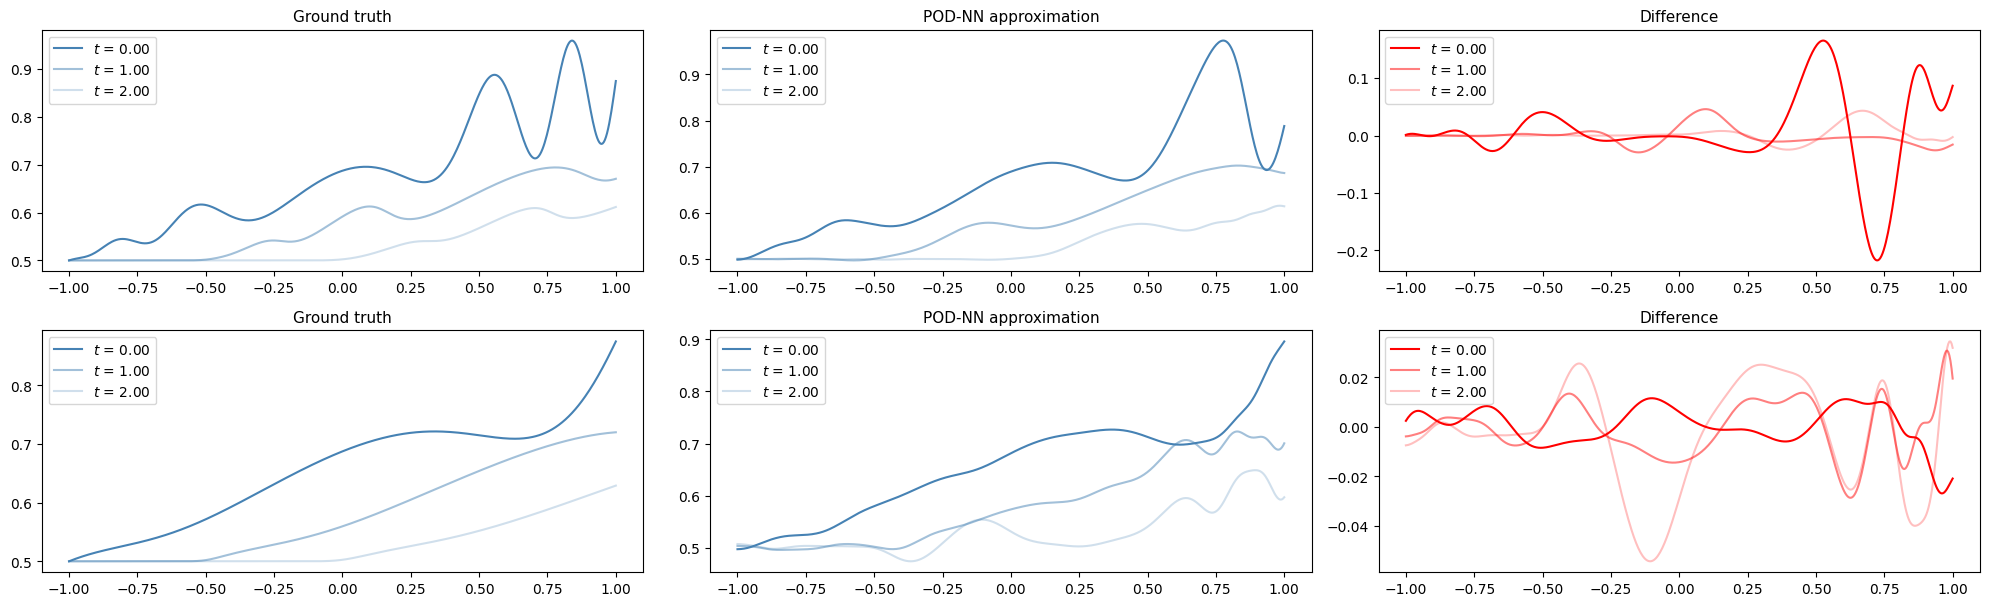

In [63]:
colors = [1.0, 0.5, 0.25]

plt.figure(figsize = (20, 30))
for i, alpha in enumerate(alpha_vals):
  input_tensor = device.tensor([[alpha, t[j]] for j in times])
  appx = np.array([rom_physics_unsupervised_miu(input_tensor[j:j+1, :]).detach().cpu().numpy() for j in range(len(times))])[:, 0, :]
  gt =  np.array([[v.values.numpy('x,vector') for v in alpha_results_list[0 if i==0 else -1]][j] for j in times]).squeeze()
  for j in range(3):
    plt.subplot(len(denormalize(alphas)),3,i*3 + 1)
    plt.plot(x.cpu(), gt[j], label = "$t$ = %.2f" % t[times[j]], alpha = colors[j], color = 'steelblue')
    plt.title("Ground truth", fontsize = 11)
    plt.legend()
    plt.subplot(len(denormalize(alphas)),3,i*3 + 2)
    plt.plot(x.cpu(), appx[j], label = "$t$ = %.2f" % t[times[j]], alpha = colors[j], color = 'steelblue')
    plt.title("POD-NN approximation", fontsize = 11)
    plt.legend()
    #plt difference
    plt.subplot(len(denormalize(alphas)),3,i*3 + 3)
    plt.plot(x.cpu(), (gt - appx)[j], label = "$t$ = %.2f" % t[times[j]], alpha = colors[j], color = 'red')
    plt.title("Difference", fontsize = 11)
    plt.legend()
plt.tight_layout()